# <center> NN-VQE

## Overview

In this tutorial, we'll show you a general framework called neural network encoded variational quantum algorithms (NN-VQAs) with TensorCircuit. NN-VQA feeds input (such as parameters of a Hamiltonian) from a given problem to a neural network and uses its outputs to parameterize an ansatz circuit for the standard VQA. Here, we take NN-variational quantum eigensolver (VQE) to illustrate concretely.

## Setup

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorcircuit as tc
import cotengra
import quimb
from tqdm.notebook import tqdm
from functools import partial

optc = cotengra.ReusableHyperOptimizer(
    methods=["greedy"],
    parallel="ray",
    minimize="combo",
    max_time=30,
    max_repeats=1024,
    progbar=True,
)
tc.set_contractor("custom", optimizer=optc, preprocessing=True)

K = tc.set_backend("tensorflow")
tc.set_dtype("complex128")

## Energy

The Hamiltonian used in this tutorial is a 1D XXZ model with periodic boundary conditions, with the transverse field strength $\lambda$ and the anisotropy parameter $\Delta$. The Hamiltonian energy expectation function is chosen as loss.

$$ \hat{H}_{XXZ}=\sum_{i}{ \left( X_{i}X_{i+1}+Y_{i}Y_{i+1}+\Delta Z_{i}Z_{i+1} \right) } + \lambda \sum_{i}{Z_{i}} $$

In [7]:
def energy(c: tc.Circuit, lamb: float = 1.0, delta: float = 1.0):
    e = 0.0
    n = c._nqubits
    for i in range(n):
        e += lamb * c.expectation((tc.gates.z(), [i]))  # <Z_i>
    for i in range(n):
        e += c.expectation(
            (tc.gates.x(), [i]), (tc.gates.x(), [(i + 1) % n])
        )  # <X_i X_{i+1}>
        e += c.expectation(
            (tc.gates.y(), [i]), (tc.gates.y(), [(i + 1) % n])
        )  # <Y_i Y_{i+1}>
        e += delta * c.expectation(
            (tc.gates.z(), [i]), (tc.gates.z(), [(i + 1) % n])
        )  # <Z_i Z_{i+1}>
    return K.real(e)

## Ansatz circuit

Now we design the circuit. We choose multi-scale entangled renormalization ansatz (MERA) as the ansatz here, $d$ is the circuit depth. (see tutorial of MERA [here](https://tensorcircuit.readthedocs.io/en/latest/tutorials/mera.html))

In [8]:
def MERA(
    inp, n, d=1, lamb=1.0, energy_flag=False
):  # for single-parameter 1D XXZ model, we fix lamb
    params = K.cast(inp["params"], "complex128")
    delta = K.cast(inp["delta"], "complex128")
    c = tc.Circuit(n)

    idx = 0

    for i in range(n):
        c.rx(i, theta=params[3 * i])
        c.rz(i, theta=params[3 * i + 1])
        c.rx(i, theta=params[3 * i + 2])
    idx += 3 * n

    for n_layer in range(1, int(np.log2(n)) + 1):
        n_qubit = 2**n_layer  # number of qubits involving
        step = int(n / n_qubit)

        for _ in range(d):  # circuit depth
            # even
            for i in range(step, n - step, 2 * step):
                c.rxx(i, i + step, theta=params[idx])
                c.rzz(i, i + step, theta=params[idx + 1])
                idx += 2

            # odd
            for i in range(0, n, 2 * step):
                c.rxx(i, i + step, theta=params[idx])
                c.rzz(i, i + step, theta=params[idx + 1])
                idx += 2

            # single qubit
            for i in range(0, n, step):
                c.rx(i, theta=params[idx])
                c.rz(i, theta=params[idx + 1])
                idx += 2

    if energy_flag:
        return energy(c, lamb, delta)  # return Hamiltonian energy expectation
    else:
        return c, idx  # return the circuit & number of circuit parameters

The number of parameters is 74


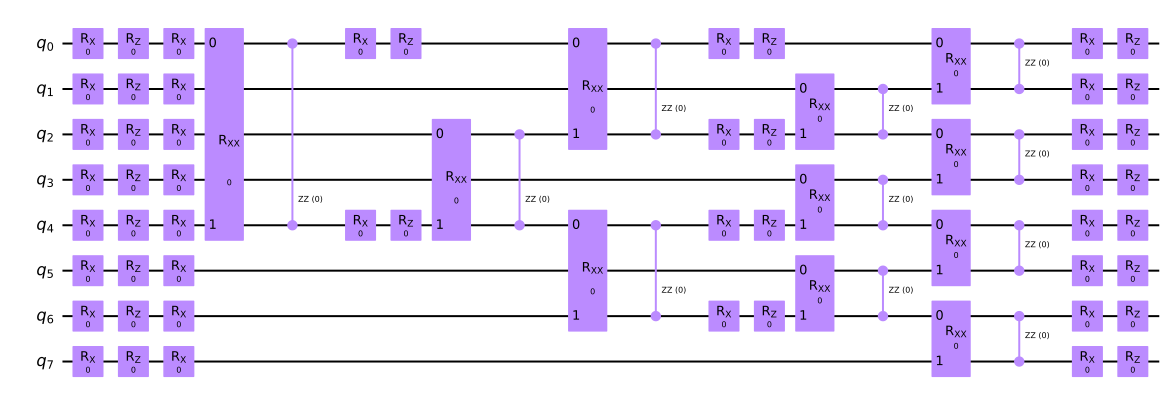

In [9]:
# circuit visulization
n = 8
d = 1
cirq, idx = MERA({"params": np.zeros(3000), "delta": 0.0}, n, d, 1.0)
print("The number of parameters is", idx)
cirq.draw()

## NN-VQE

Design the NN-VQE. We use a neural network to transform the Hamiltonian parameters to the optimized parameters in the PQC for VQE.

In [10]:
def NN_MERA(n, d, lamb, NN_shape, stddev):
    input = tf.keras.layers.Input(shape=[1])  # input layer

    x = tf.keras.layers.Dense(
        units=NN_shape,
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=stddev),
        activation="ReLU",
    )(
        input
    )  # hidden layer

    x = tf.keras.layers.Dropout(0.05)(x)  # dropout layer

    _, idx = MERA(
        {"params": np.zeros(3000), "delta": 0.0}, n, d, 1.0, energy_flag=False
    )
    params = tf.keras.layers.Dense(
        units=idx,
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=stddev),
        activation="sigmoid",
    )(
        x
    )  # output layer

    qlayer = tc.KerasLayer(partial(MERA, n=n, d=d, lamb=lamb, energy_flag=True))  # PQC

    output = qlayer({"params": 6.3 * params, "delta": input})  # NN-VQE output

    m = tf.keras.Model(inputs=input, outputs=output)

    return m

## Train

Now we can train the NN-VQE with TensorFlow.

In [23]:
def train(n, d, lamb, delta, NN_shape, maxiter=10000, lr=0.005, stddev=1.0):
    exp_lr = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr, decay_steps=1000, decay_rate=0.7
    )
    opt = tf.keras.optimizers.Adam(exp_lr)  # optimizer

    m = NN_MERA(n, d, lamb, NN_shape, stddev)
    for i in range(maxiter):
        with tf.GradientTape() as tape:
            e = tf.zeros([1], dtype=tf.float64)
            for de in delta:
                e += m(K.reshape(de, [1]))  # sum up energies of all training points
        grads = tape.gradient(e, m.variables)
        opt.apply_gradients(zip(grads, m.variables))
        if i % 500 == 0:
            print("epoch", i, ":", e)

    m.save_weights("NN-VQE.weights.h5")  # save the trained model

In [24]:
n = 8  # number of qubits
d = 2  # circuit depth
lamb = 0.75  # fixed
delta = np.linspace(-3.0, 3.0, 20, dtype="complex128")  # training set
NN_shape = 20  # node number of the hidden layer
maxiter = 2500  # maximum iteration for the optimization
lr = 0.009  # learning rate
stddev = 0.1  # the initial standard deviation of the NN

with tf.device("/cpu:0"):
    train(n, d, lamb, delta, NN_shape=NN_shape, maxiter=maxiter, lr=lr, stddev=stddev)

epoch 0 : tf.Tensor([[117.53523392]], shape=(1, 1), dtype=float64)
epoch 500 : tf.Tensor([[-361.85937039]], shape=(1, 1), dtype=float64)
epoch 1000 : tf.Tensor([[-365.35288984]], shape=(1, 1), dtype=float64)
epoch 1500 : tf.Tensor([[-366.65891358]], shape=(1, 1), dtype=float64)
epoch 2000 : tf.Tensor([[-366.94258369]], shape=(1, 1), dtype=float64)


## Test

We use a test set beyond the training set to test the accuracy and generalization capability of NN-VQE.

In [47]:
test_delta = np.linspace(-4.0, 4.0, 201)  # test set
test_energies = tf.zeros_like(test_delta).numpy()
m = NN_MERA(n, d, lamb, NN_shape, stddev)
m.load_weights("DNN-MERA_2[20](-3.0,3.0,20)_drop05.weights.h5")
for i, de in tqdm(enumerate(test_delta)):
    test_energies[i] = m(K.reshape(de, [1]))

0it [00:00, ?it/s]

## Compare

We compare the results of NN-VQE with the analytical ones to calculate the ground-state relative error. From the figure, we can see that NN-VQE is able to estimate the ground-state energies of parameterized Hamiltonians with high precision without fine-tuning and has a favorable generalization capability.

In [48]:
analytical_energies = []  # analytical result
for i in test_delta:
    h = quimb.tensor.tensor_builder.MPO_ham_XXZ(
        n, i * 4, jxy=4.0, bz=2.0 * 0.75, S=0.5, cyclic=True
    )
    h = h.to_dense()
    analytical_energies.append(np.min(quimb.eigvalsh(h)))

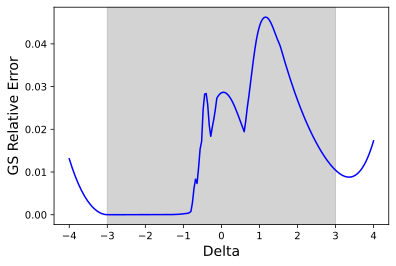

In [49]:
# relative error
plt.plot(
    test_delta,
    (test_energies - analytical_energies) / np.abs(analytical_energies),
    "-",
    color="b",
)
plt.xlabel("Delta", fontsize=14)
plt.ylabel("GS Relative Error", fontsize=14)
plt.axvspan(-3.0, 3.0, color="darkgrey", alpha=0.5)  # training set span
plt.show()

To get more detailed information or further study, please refer to [our paper](https://arxiv.org/abs/2308.01068) and [GitHub](https://github.com/JachyMeow/NN-VQA).